# CliMA GCM simple plot example

In [46]:
# setup modules 
import numpy as np
from netCDF4 import Dataset
import iris
from scipy import signal
import iris.analysis.cartography
import fnmatch
import os
from matplotlib import animation, rc
from IPython.display import HTML

import iris.plot as iplt
import matplotlib.pyplot as plt
import iris.quickplot as qplt


## Combine files and extract data
- iris is used here inly for the aggrgation (to be repaced by Tobi's aggregation.jl script)

In [47]:
# import data per variable
from glob import glob

filenames = '/central/groups/esm/lenka/VizCLIMA_data/HeldSuarez_AtmosDefault_GCM*.nc'
file_names = sorted(glob(filenames))

# this loads one or all variables as cubes with time as a new dimension
def load_variable(file_names, varname):
    lfn = len(file_names)
    simtime_cubes = iris.load(file_names)[:lfn]   
    if varname == 'all':
        len_vars = (len(iris.load(file_names)) / lfn) -1
        cubes_all = iris.cube.CubeList()
        for v_i in np.arange(len_vars):
            cubes = (iris.load(file_names)[lfn:])[lfn*v_i:lfn*(v_i+1)]
            for i,cube in enumerate(cubes):
                cube.add_aux_coord(iris.coords.AuxCoord((simtime_cubes[i]).data, "time", long_name = "simtime", units="seconds"))
            cubes_all.append(cubes.merge_cube())    
        return cubes_all        
    else:
        cubes = iris.load(file_names, varname)
        for i,cube in enumerate(cubes):
            cube.add_aux_coord(iris.coords.AuxCoord((simtime_cubes[i]).data, "time", long_name = "simtime", units="seconds"))
        return cubes.merge_cube()
    
#cube_u = load_variable(file_names, 'u')
#print cube_u
#print cube_u.coord('time')[:]

cubes_all = load_variable(file_names, 'all')
print cubes_all
print cubes_all[5].coord('time')[:]

# note the indices for each variable (will be useful below)



0: u / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
1: T / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
2: w / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
3: v / (1)                             (time: 27; long: 73; lat: 37; rad: 31)
4: thd / (1)                           (time: 27; long: 73; lat: 37; rad: 31)
5: vortrel / (1)                       (time: 27; long: 73; lat: 37; rad: 31)
DimCoord(array([  98346.31,  196690.06,  295033.8 ,  393377.56,  491721.3 ,
        590085.94,  688460.94,  786835.94,  885210.94,  983585.94,
       1081960.9 , 1180335.9 , 1278710.9 , 1377085.9 , 1475460.9 ,
       1573835.9 , 1672210.9 , 1770585.9 , 1868960.9 , 1967335.9 ,
       2065710.9 , 2164000.8 , 2262250.8 , 2360500.8 , 2458750.8 ,
       2557000.8 , 2655250.8 ], dtype=float32), standard_name='time', units=Unit('seconds'), long_name='simtime')


In [52]:
# coord info
lo = cubes_all[5].coord('long')[:]
la = cubes_all[5].coord('lat')[:]
ra = cubes_all[5].coord('rad')[:]
timestep = cubes_all[5].coord('time')[:]

lat = np.array(la.points)
lon = np.array(lo.points)
rad = np.array(ra.points)
time = np.array(timestep.points)

# vars:
u_raw = (cubes_all[0]).data
T_raw = (cubes_all[1]).data
theta_raw = (cubes_all[4]).data

# check that the var dimensions are [time, lon, lat, rad] - if not then change below
print len(rad)
print len(lat)
print len(lon)

print np.shape(u_raw)

t_dim = 0
rad_dim = 3
lat_dim = 2
lon_dim = 1


31
37
73
(27, 73, 37, 31)


## Zonal mean view

### 1. Time mean plots

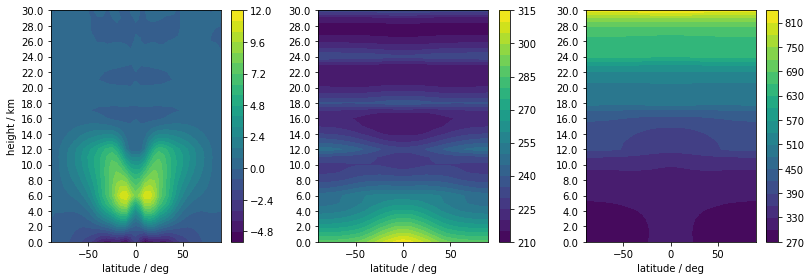

In [53]:
# zonal wind, temperature and potential temperature

u_zmtm =     np.transpose(np.mean(u_raw,axis=(t_dim,lon_dim)) )
T_zmtm =     np.transpose(np.mean(T_raw,axis=(t_dim,lon_dim)) )
theta_zmtm = np.transpose(np.mean(theta_raw,axis=(t_dim,lon_dim)) )


plt.figure(figsize=(15,4))
plt.subplot(141)
c = plt.contourf( lat,rad, u_zmtm ,20)
plt.yticks(rad[::2],(rad[::2]-6371000.)/1000.)
plt.ylabel('height / km')
plt.xlabel('latitude / deg')
plt.colorbar(c)

plt.subplot(142)
c = plt.contourf( lat,rad, T_zmtm ,20)
plt.yticks(rad[::2],(rad[::2]-6371000.)/1000.)
plt.xlabel('latitude / deg')
plt.colorbar(c)

plt.subplot(143)
c = plt.contourf( lat,rad, theta_zmtm ,20)
plt.yticks(rad[::2],(rad[::2]-6371000.)/1000.)
plt.xlabel('latitude / deg')
plt.colorbar(c)
                        
plt.tight_layout()


### 2. Animation

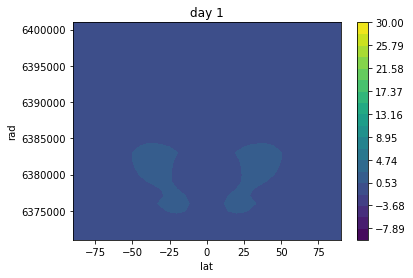

In [63]:
%%capture
%matplotlib inline

# choose which to plot
var_anim = np.mean(u_raw,axis=(lon_dim)) 

# Initialise plot
rnge = np.linspace(-10,30,20)# u
#rnge = np.linspace(310,340,20)# pot temp
#rnge = np.linspace(-9e-6,9e-6,20)# vort

x,y = np.meshgrid(lat,rad)
fig = plt.figure() 
plt.xlabel(r'lat')
plt.ylabel(r'rad')
init = plt.contourf(x, y, np.transpose(var_anim[0,:,:])*np.nan, rnge); plt.colorbar(init)

t = np.array(time)/60./60./24.

# animation function
def update(i): 
    z = var_anim[i,:,:]
    cont = plt.contourf(x, y, np.transpose(z), rnge)
    plt.title(r'day %s' % int(t[i]))    
    return cont  

# create animatoin
anim = animation.FuncAnimation(fig, update, frames = np.arange(len(t)), interval=200)

# enable inline display in the notebook
HTML(anim.to_jshtml())
rc('animation', html='jshtml')

In [64]:
# display
anim

## Horizontal plane view

In [68]:
# e.g. get upper level, say 10 km altitude

print ((rad[:]-6371000.)/1000.).astype(int)

# choose level - e.g. 10km
lev_i =[i for i, x in enumerate((rad[:]-6371000.)/1000.) if x == 10][0]
 
# Choose variable and its range
var = u_raw*1.
rnge = np.linspace(-10,30,20)# u
#rnge = np.linspace(310,340,20)# pot temp
#rnge = np.linspace(-9e-6,9e-6,20)# vort

# slice at the rad dimension
slc = [slice(None)] * len(var.shape)
slc[rad_dim] = slice(lev_i,lev_i+1)
var_anim = np.squeeze(var[slc])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


### 1. Animation

In [70]:
%%capture
%matplotlib inline

# Initialise plot
x,y = np.meshgrid(lon,lat)
fig = plt.figure() 
plt.xlabel(r'lon')
plt.ylabel(r'lat')
init = plt.contourf(x, y, np.transpose(var_anim[0,:,:])*np.nan, rnge); plt.colorbar(init)

t = np.array(time)/60./60./24.

# animation function
def update(i): 
    z = var_anim[i,:,:]
    cont = plt.contourf(x, y, np.transpose(z), rnge)
    plt.title(r'day %s' % int(t[i]))    
    return cont  

# create animatoin
anim = animation.FuncAnimation(fig, update, frames = np.arange(len(t)), interval=200)

# enable inline display in the notebook
HTML(anim.to_jshtml())
rc('animation', html='jshtml')

In [71]:
# display
anim